In [70]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

Описание данных:
    * id -- идентификатор мотора
    * cycle -- цикл работы
    * p00-p20 -- показания датчиков считываемые в процессе работы
    * s0, s1 -- настройки изменяемые в конце каждого цикла

In [71]:
data = pd.read_csv('data.csv')

In [72]:
data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16138 entries, 0 to 16137
Data columns (total 25 columns):
id       16138 non-null int64
cycle    16138 non-null int64
p00      16138 non-null float64
p01      16138 non-null float64
p02      16138 non-null float64
p03      16138 non-null float64
p04      16138 non-null float64
p05      16138 non-null float64
p06      16138 non-null float64
p07      16138 non-null float64
p08      16138 non-null int64
p09      16138 non-null int64
p10      16138 non-null int64
p11      16138 non-null float64
p12      16138 non-null float64
p13      16138 non-null float64
p14      16138 non-null float64
p15      16138 non-null float64
p16      16138 non-null float64
p17      16138 non-null float64
p18      16138 non-null float64
p19      16138 non-null float64
p20      16138 non-null float64
s1       16138 non-null float64
s2       16138 non-null float64
dtypes: float64(20), int64(5)
memory usage: 3.1 MB


#### Судя по посатновке задания, нужно решить задачу классификации
#### Ниже я ищу максимальный цикл для каждого двигателя, для того, чтобы далее ввести метки классов

In [73]:
max_cycle = data.groupby(['id'])['cycle'].max().reset_index()

In [74]:
full_data = pd.merge(data, max_cycle, on=['id'], how='left')

In [75]:
full_data.head()

,id,cycle_x,p00,p01,p02,p03,p04,p05,p06,p07,p08,p09,p10,p11,p12,p13,p14,p15,p16,p17,p18,p19,p20,s1,s2,cycle_y
0,1,1,518.67,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100,641.82,39.06,23.4190,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,-0.0007,-0.0004,192
1,1,2,518.67,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100,642.15,39.00,23.4236,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,0.0019,-0.0003,192
2,1,3,518.67,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100,642.35,38.95,23.3442,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,-0.0043,0.0003,192
3,1,4,518.67,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100,642.35,38.88,23.3739,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,0.0007,0.0000,192
4,1,5,518.67,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100,642.37,38.90,23.4044,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,-0.0019,-0.0002,192


#### Смотрю соотношение полученных классов и они получились очень несбалансированными

In [76]:
full_data['will_brake'] = (full_data.cycle_x == full_data.cycle_y).map({True:1, False:0})
full_data.drop('cycle_y', inplace=True, axis=1)
print(full_data.will_brake.value_counts(normalize=True))

0    0.995043
1    0.004957
Name: will_brake, dtype: float64


#### Строю heatmap, чтобы понять, есть ли в дата сете коррелирующие признаки

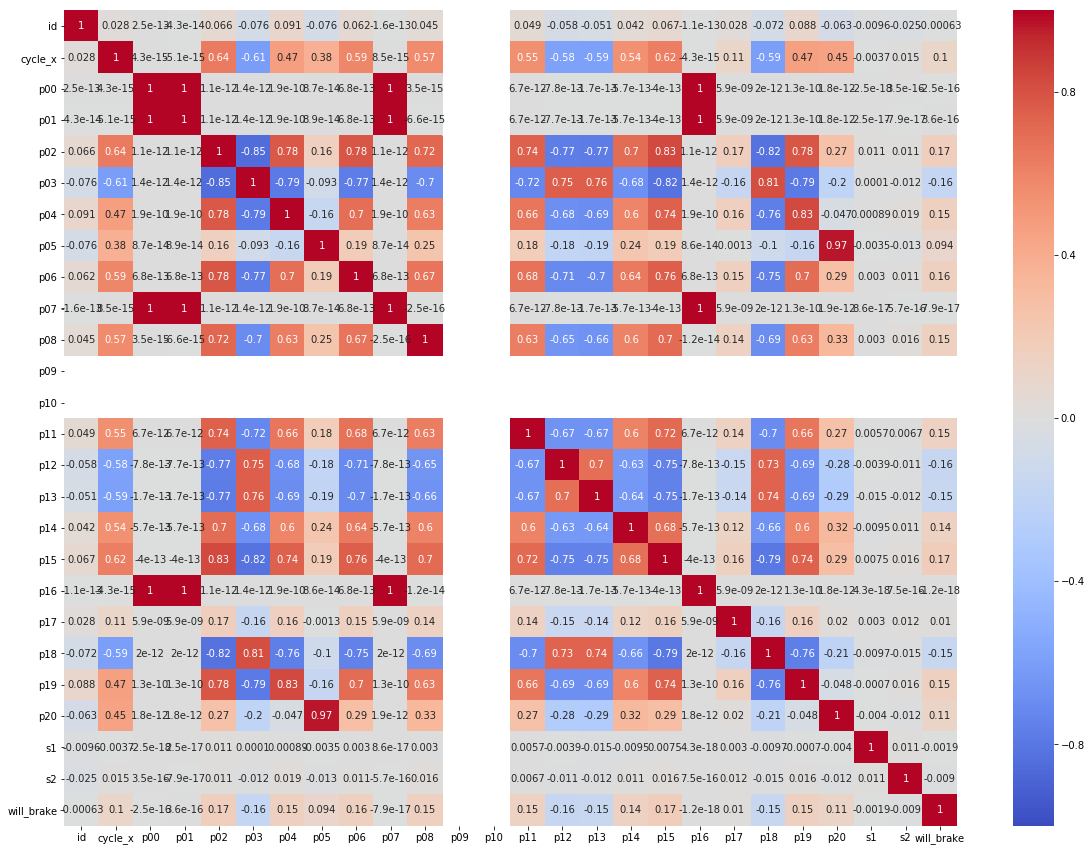

In [77]:
plt.figure(figsize=(20,15))
sns.heatmap(full_data.corr(),
            vmin=-1,
            cmap='coolwarm',
            annot=True);

#### Помещаю коррелирующие признаки и признаки, которые не оказывают никакого влияния в список, чтобы далее удалить их из дата сета

In [78]:
corr_matrix = full_data.corr()
NullField = [i for i in corr_matrix if corr_matrix[i].isnull().values[0]]

In [79]:
CorrField = []
for i in corr_matrix:
    for j in corr_matrix.index[corr_matrix[i] > 0.9]:
        if i != j and j not in CorrField and i not in CorrField:
            CorrField.append(j)
CorrField

['p01', 'p07', 'p16', 'p20']

In [80]:
Drop = NullField + CorrField

new_data = full_data.drop(Drop, axis=1)

In [81]:
new_data.head()

,id,cycle_x,p00,p02,p03,p04,p05,p06,p08,p11,p12,p13,p14,p15,p17,p18,p19,s1,s2,will_brake
0,1,1,518.67,47.47,521.66,2388.02,8138.62,8.4195,392,641.82,39.06,23.4190,1589.70,1400.60,21.61,554.36,2388.06,-0.0007,-0.0004,0
1,1,2,518.67,47.49,522.28,2388.07,8131.49,8.4318,392,642.15,39.00,23.4236,1591.82,1403.14,21.61,553.75,2388.04,0.0019,-0.0003,0
2,1,3,518.67,47.27,522.42,2388.03,8133.23,8.4178,390,642.35,38.95,23.3442,1587.99,1404.20,21.61,554.26,2388.08,-0.0043,0.0003,0
3,1,4,518.67,47.13,522.86,2388.08,8133.83,8.3682,392,642.35,38.88,23.3739,1582.79,1401.87,21.61,554.45,2388.11,0.0007,0.0000,0
4,1,5,518.67,47.28,522.19,2388.04,8133.80,8.4294,393,642.37,38.90,23.4044,1582.85,1406.22,21.61,554.00,2388.06,-0.0019,-0.0002,0


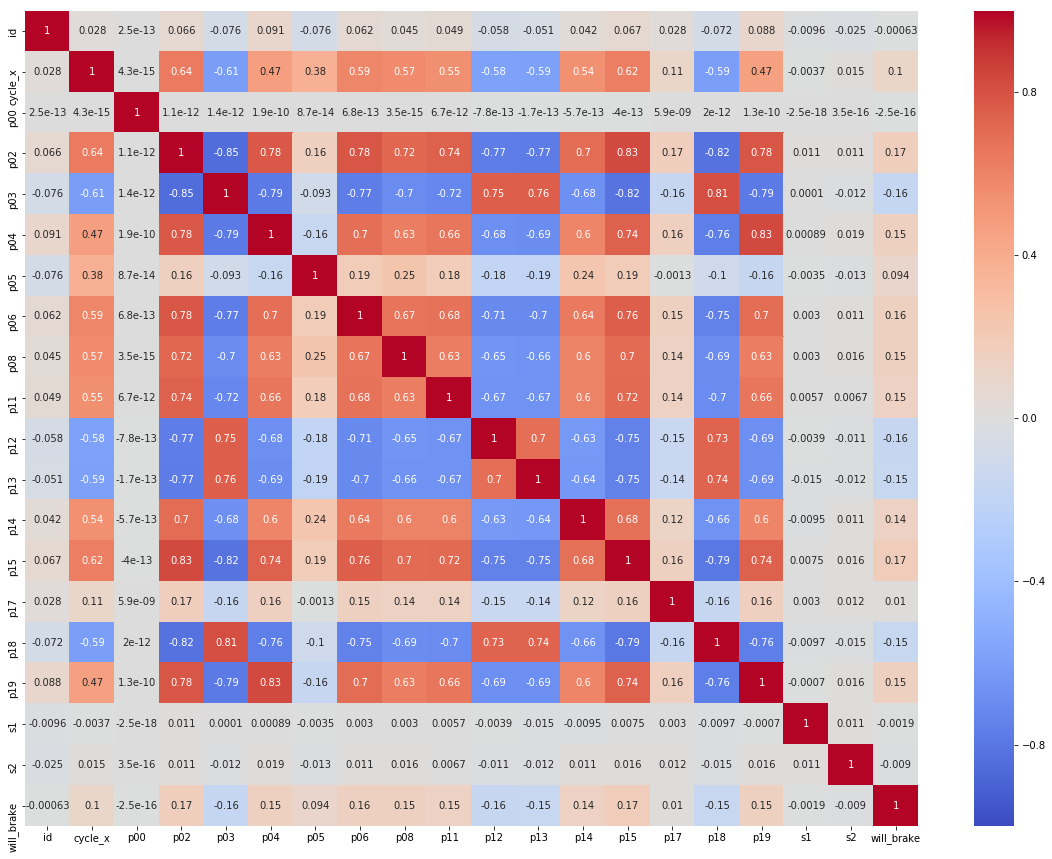

In [82]:
plt.figure(figsize=(20,15))
sns.heatmap(new_data.corr(),
            vmin=-1,
            cmap='coolwarm',
            annot=True);

In [83]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, accuracy_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

In [84]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [85]:
X = new_data.drop('will_brake', axis=1)
y = new_data['will_brake']

x_train, x_test, \
y_train, y_test, = train_test_split(X,
                                               y,
                                               test_size = 0.4,
                                               random_state=12)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((9682, 19), (6456, 19), (9682,), (6456,))

In [86]:
y_train.value_counts()

0    9632
1      50
Name: will_brake, dtype: int64

#### Так как признаки в дата сете довольно разношерстные, что я решил их масштабировать

In [87]:
encoder = StandardScaler()

x_train_scaled = encoder.fit_transform(x_train)
x_test_scaled = encoder.fit_transform(x_test)

In [88]:
models = []
models.append(RandomForestClassifier(n_estimators=165, max_depth=4))
models.append(KNeighborsClassifier(n_neighbors=20))
models.append(XGBClassifier())
models.append(LogisticRegression(class_weight='balanced'))

#### Так как классы очень несбалансированы, то я также решил провести over sampling для увеличеия объктов наименьшего класса

In [89]:
sm = SMOTE(random_state=12, ratio = 1.0)
x_train_res, y_train_res = sm.fit_sample(x_train_scaled, y_train)

In [94]:
d = pd.DataFrame(y_train_res)
d[0].value_counts()

1    9632
0    9632
Name: 0, dtype: int64

#### Далее я провожу сравнение алгоритмов RandomForest, KNeighbors, XGBoost, LogisticRegression, строя PR кривую, вычисля площадь под графиком, а также вычисляя recall

RandomForestClassifier   AUC: 36.20246359084133
RandomForestClassifier  recall_score: 0.8666666666666667
KNeighborsClassifier   AUC: 2.298476402661296
KNeighborsClassifier  recall_score: 0.9666666666666667
XGBClassifier   AUC: 37.02427308232867
XGBClassifier  recall_score: 0.6666666666666666
LogisticRegression

C:\Users\Vlad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


   AUC: 58.7987132968094
LogisticRegression  recall_score: 0.9666666666666667


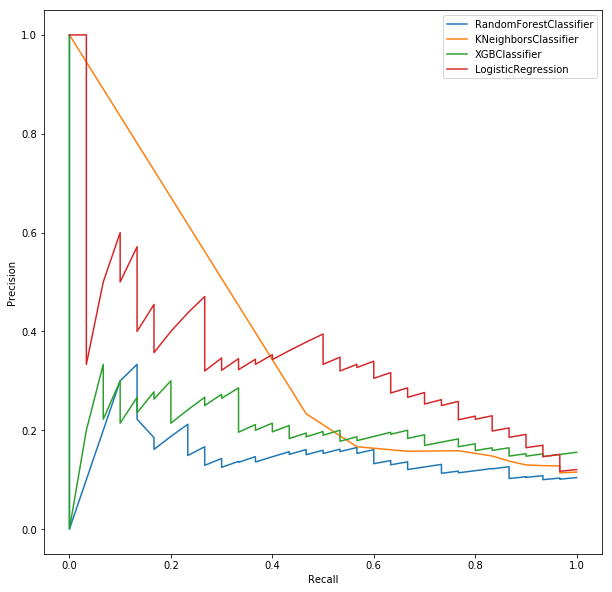

In [98]:
from scipy.integrate import simps
plt.figure(figsize=(10,10))
for model in models:
    model.fit(x_train_res, y_train_res)
    pred = model.predict_proba(x_test_scaled)[:,1]
    precision, recall, _ = precision_recall_curve(y_test, pred)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.plot(recall, precision, label=str(model).split('(')[0])
    print(str(model).split('(')[0], '  AUC:',simps(precision))
    print(str(model).split('(')[0], ' recall_score:',recall_score(y_test, model.predict(x_test_scaled)))
    plt.legend();

#### LogisticRegression показал себя лучше всего, но recall_score мне кажется слишком высоким, что подозрительно. Поэтому далее я решил подобрать опимальные параметры с помощью GridSearch

In [99]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
cv = 5

In [104]:
estimator = LogisticRegression(class_weight='balanced', solver='liblinear')
optimizer = GridSearchCV(estimator, param_grid, cv=cv)
optimizer.fit(x_train_res, y_train_res)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [105]:
recall_score(y_test, optimizer.best_estimator_.predict(x_test_scaled))

0.8666666666666667

## Вывод
После удаления коррелирующих признаков, масштабирования признаков и применения oversampling мне удалось получить полноту = 0.86. Я пробовал и другие способы, но это лучшее, что у мне удалось получить на данный момент. В качестве метрики я выбрал recall score, так как выборка была сильно несбалансирована, accurancy же здесь совершенно нерепрезентативена, так как если бы у меня была модел a(x) = 0, то на тестовой выборке accurancy была бы все рано высокой из-за преобладания класса с меткой 0.

Варианты использования полученной модели на практике:
- В автосервисе при прохождении ТО, чтобы предотвратить поломку двигателя во время движения
- В системе встроенной в автомобиль, опять таки для предупреждения водителя о возможной поломке
- При тестировании двигателя при производстве
- Для составения рейтинга надежности двигателей
- Также на данный момент существует глобальный тренд в машиностроении и обслуживании машин Predictive maintenance, то есть 
на различные части поездов(двигатели, колодки и так далее), тракторы, станки ставятся датчики, чтобы заранее предупредить поломку и обнаружить в чем проблема
- Smart grid - повышение энергоэффективности. Компании стремятся тщательно следить за распределением электроэнергии с помощью датчиков

Доп. задача: Составить предиктивную модель отказа мотора в зависимости от показания датчиков, считываемых в процессе работы, цикла и параметов, изменяемых в конце каждого цикла.